# GraphConvNets

In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../data generation')
sys.path.insert(0,'../model architecture')

In [2]:
from data_generator import load_dataset
from models import *
from experiment_tools import *
from params import *

Using backend: pytorch


## Dataset
### Set hyper-parameters: dataset

In [3]:
test_cases, dataset_size, std_scaler, test_type = get_test_params()

### Select a dataset

In [4]:
idx = 0
test_case = test_cases[idx]
test_case

'pglib_opf_case24_ieee_rts.m'

### Load a dataset

In [5]:
dataset = load_dataset(test_case=test_case,
                       dataset_size=dataset_size,
                       std_scaler=std_scaler,
                       test_type=test_type,
                       gen_only=True)

### Check the shape of the dataset
- number of samples
- number of buses
- number of generators

In [6]:
# (num_samples, num_buses),(num_samples, num_gens) 
dataset['x'].shape, dataset['y'].shape 

((300, 24, 1), (300, 24, 6))

### Check the shape of the graph

In [7]:
g = get_graph_structure(dataset['g'])

In [8]:
dataset['g'].keys()

dict_keys(['bus_idx', 'fbus2tbus', 'gen_bus_idx'])

In [9]:
dataset['g']['bus_idx'].shape, dataset['g']['fbus2tbus'].shape, dataset['g']['gen_bus_idx'].shape

((24,), (38, 2), (33, 1))

In [10]:
g

Graph(num_nodes=24, num_edges=100,
      ndata_schemes={}
      edata_schemes={})

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

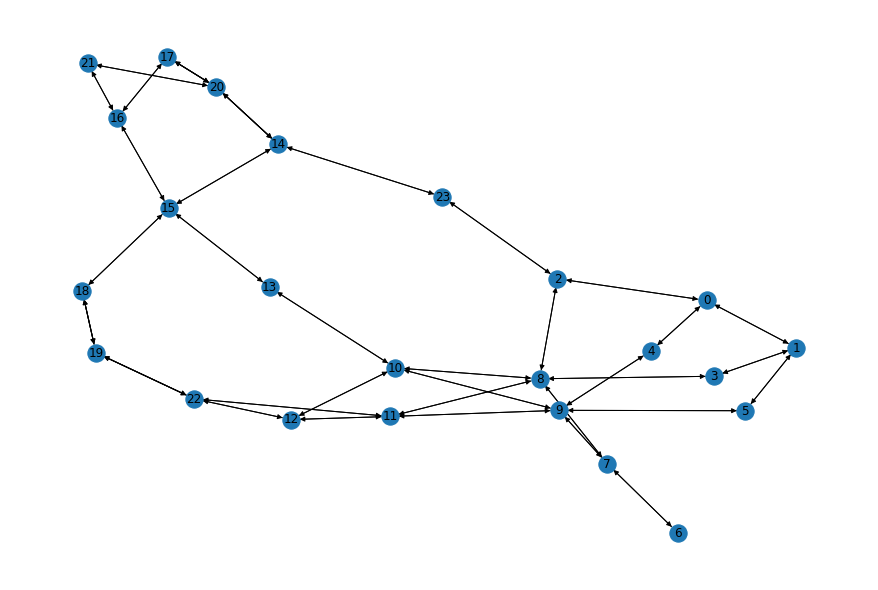

In [12]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

## Model
### Set hyper-parameters: model

In [13]:
model_name = "gcn"
num_epochs, batch_size, lr = get_h_params(model_name)

### Set data-loaders

In [14]:
train_loader, val_loader, test_loader = data_prep(dataset=dataset,
                                                  batch_size=batch_size)

/Users/jeehyunpark/Library/Mobile Documents/com~apple~CloudDocs/jhyun/UT/EE 394V - DATA ANALYTICS POWER SYS/Project_EE394V_SPR2021/code/experiments/experiment_tools.py:31: RuntimeWarning: invalid value encountered in true_divide
  x_normed = np.nan_to_num(dataset["x"] / dataset["x"].max(axis=0), nan=0.0)


### Check the shape of the data-loaders
- number of batch
- number of buses
- number of generators

In [15]:
feature, label = next(iter(train_loader))
feature.shape, label.shape

(torch.Size([32, 24, 1]), torch.Size([32, 24, 6]))

In [16]:
feature, label = next(iter(val_loader))
feature.shape, label.shape

(torch.Size([32, 24, 1]), torch.Size([32, 24, 6]))

In [17]:
feature, label = next(iter(test_loader))
feature.shape, label.shape

(torch.Size([1, 24, 1]), torch.Size([1, 24, 6]))

### Set a model

In [18]:
class GraphConvNet(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConvNet, self).__init__()
        self.gcn_1 = GraphConv(in_feats, 100)
        self.gcn_2 = GraphConv(100, 200)
        self.gcn_3 = GraphConv(200, out_feats)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        print(x.size())
        x = self.gcn_1(g, x)
        x = self.elu(x)
        print(x.size())
        x = self.gcn_2(g, x)
        x = self.elu(x)
        print(x.size())
        x = self.gcn_3(g, x)
        x = self.sigmoid(x)
        print(x.size())
        return x

In [20]:
gcn = GraphConvNet(in_feats=feature.shape[2], out_feats=label.shape[2]) # num_bus / num_gen

# loss object???
loss_func = nn.BCELoss()
# loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(gcn.parameters(), lr=lr, momentum=0.9)

gcn.eval()

GraphConvNet(
  (gcn_1): GraphConv(in=1, out=100, normalization=both, activation=None)
  (gcn_2): GraphConv(in=100, out=200, normalization=both, activation=None)
  (gcn_3): GraphConv(in=200, out=6, normalization=both, activation=None)
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
)

### Train the model

In [21]:
train(net=gcn,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      loss_func=loss_func,
      model_name=model_name,
      dataset_name=test_case,
      g=g,
      num_epochs=num_epochs)

> case: pglib_opf_case24_ieee_rts
> model: gcn
- num of params: 21606
- training
torch.Size([32, 24, 1])


RuntimeError: The size of tensor a (32) must match the size of tensor b (24) at non-singleton dimension 0

### Test the model

In [33]:
test(net=gcn,
     test_loader=test_loader,
     model_name="gcn",
     dataset_name=test_case,
     g=g)

- testing


FileNotFoundError: [Errno 2] No such file or directory: './weights/pglib_opf_case24_ieee_rts/gcn.pt'